In [1]:
# import data
import pandas as pd
df_train = pd.read_csv('traindata.csv')
df_train.head()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f28,f29,f30,f31,f32,f33,f34,f35,f36,class
0,1,3.014650e-02,0.290527,0.128257,0.0,0.252778,0.059602,0.505796,0.012509,0.212368,...,1.0,0.876635,0.611510,0.211560,0.316226,0.111492,0.641685,0.401401,0.016396,0
1,2,1.547020e-02,0.042356,0.119280,0.0,0.709655,0.030953,0.499796,0.028063,0.076510,...,1.0,0.123842,0.451209,0.107106,0.689359,0.167189,0.948426,0.309309,0.048419,1
2,3,4.992840e-07,0.020987,0.136789,0.0,0.515774,0.000001,0.499284,0.011618,0.057305,...,1.0,0.860399,0.437531,0.060508,0.344425,0.107430,0.485500,0.471071,0.083594,1
3,4,2.124110e-03,0.154123,0.138232,0.0,-0.129109,0.004426,0.479916,0.066398,0.142775,...,1.0,0.840820,0.328107,0.129720,0.179181,0.257383,0.819967,0.496096,0.001510,0
4,5,8.220470e-03,0.039986,0.148519,0.0,0.679252,0.016546,0.496825,0.001246,0.072317,...,1.0,0.110789,0.405004,0.127449,0.670417,0.034923,0.505427,0.269670,0.047439,1


In [2]:
features = df_train.columns[1:36]
label = df_train.columns[37]

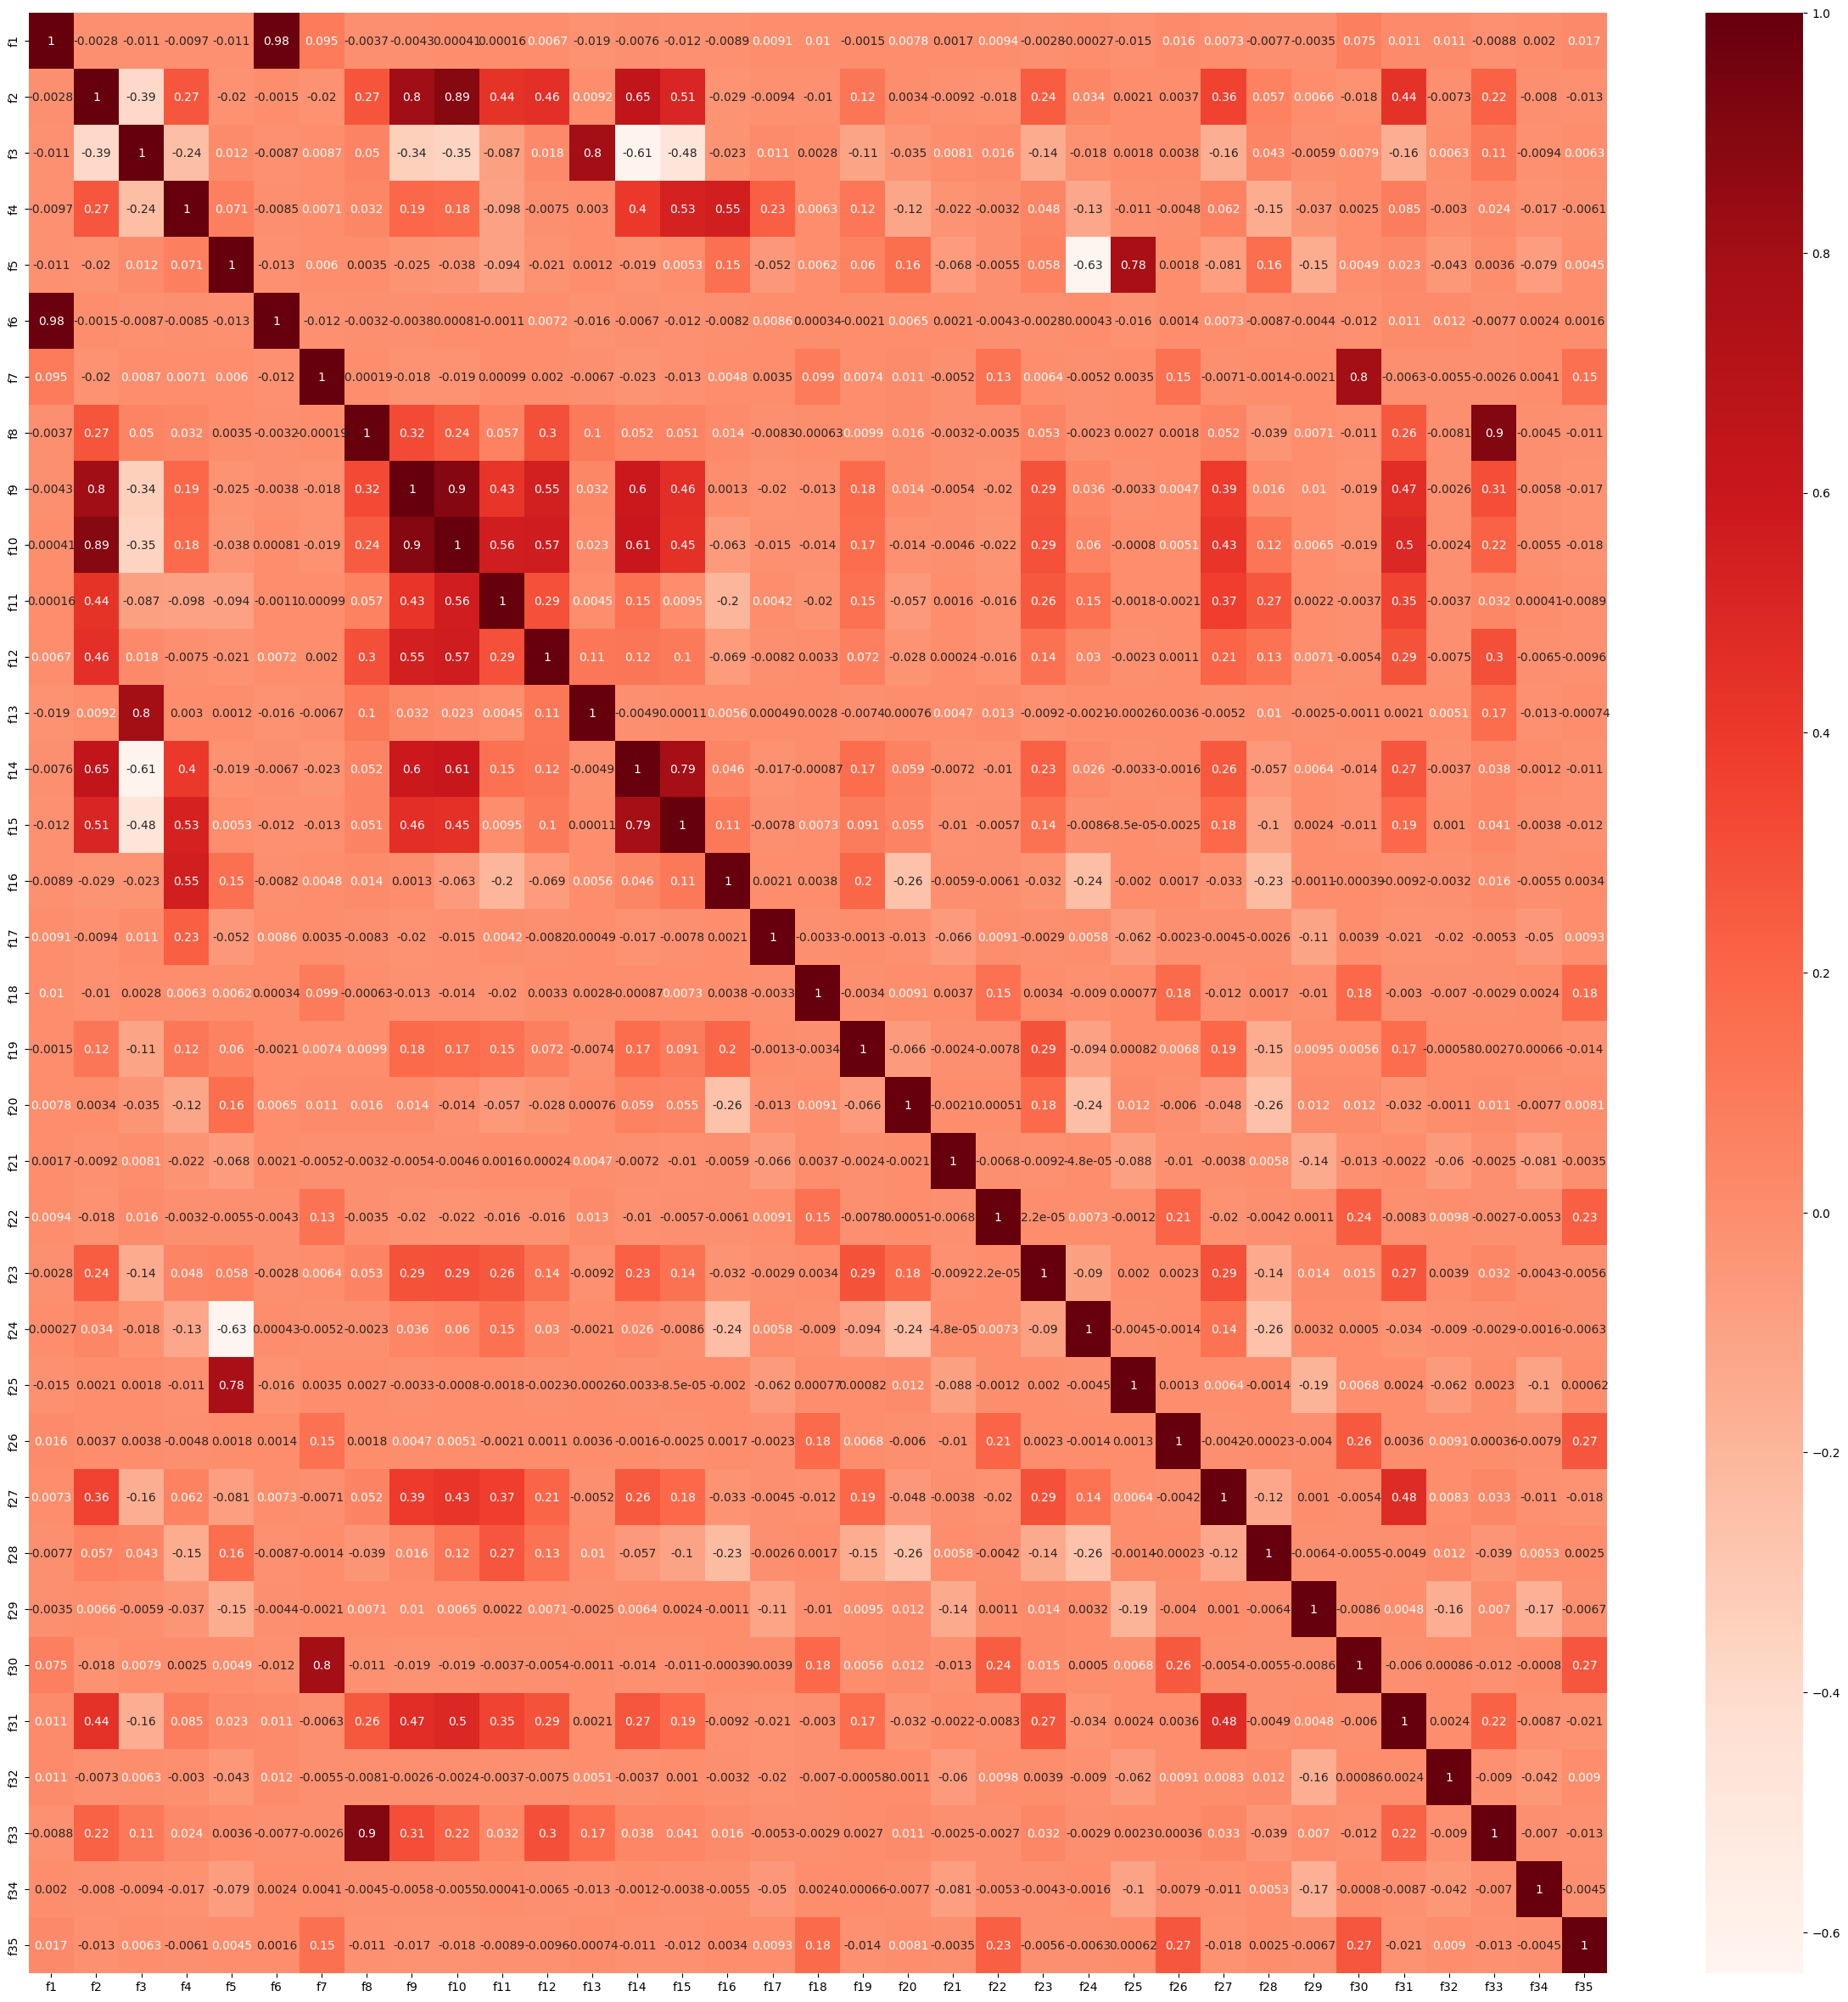

In [3]:
# Correlation check
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_train[features].corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if abs(corr[features[i]][features[j]]) >= 0.8:
            print(features[i], features[j], corr[features[i]][features[j]])
            corr_pairs.append((features[i], features[j]))

f1 f6 0.9838147117866063
f2 f9 0.804954752962555
f2 f10 0.8943791331957232
f8 f33 0.9044178507778071
f9 f10 0.9004505779287568


In [5]:
# Regress all features on label and give the linear regression model and p-values for each feature
import statsmodels.api as sm
model = sm.OLS(df_train[label], df_train[features]).fit()
# List of features that have p-value > 0.05
model.summary()
model.pvalues[model.pvalues > 0.05]

f16    0.253518
f18    0.832295
f24    0.640307
f26    0.693417
f32    0.168165
f33    0.104372
dtype: float64

In [19]:
# Performe stepwise regression
import statsmodels.formula.api as smf
def backwardElimination(x, y, sl):
    numVars = len(x.columns)
    for i in range(0, numVars):
        regressor_OLS = sm.Logit(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if regressor_OLS.pvalues[j] == maxVar:
                    x = x.drop(x.columns[j], axis=1)
    regressor_OLS.summary()
    return x

SL = 0.05
data_modeled = backwardElimination(df_train[features], df_train[label], SL)

Optimization terminated successfully.
         Current function value: 0.634521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634546
  

In [20]:
candidate_features = data_modeled.columns
print(candidate_features)

Index(['f2', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16',
       'f19', 'f20', 'f23', 'f24', 'f27', 'f31'],
      dtype='object')


In [21]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train[candidate_features], df_train[label], test_size=0.2, random_state=42)

In [22]:
# calculate the log loss of the model
import numpy as np
import math
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -math.log(p)
    else:
        return -math.log(1 - p)

In [17]:
# Loop through all basic machine learning models and find the best model with the lowest log loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# SVC Linear
from sklearn.svm import LinearSVC
models = [LogisticRegression(), SVC(probability=True), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), GradientBoostingClassifier(), LinearSVC()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred_binary = model.predict(X_test)
    print(model.score(X_test, y_test))
    # loglosses = []
    # for i in range(len(y_pred)):
    #     loglosses.append(logloss(y_test.values[i], y_pred[i][y_test.values[i]]))
    # print(model, np.mean(loglosses))

In [23]:
rw = RandomForestClassifier(n_estimators=500,random_state=42)
rw.fit(X_train, y_train)
rw.score(X_test, y_test)

0.71875

In [24]:
# fit an light gradient boosting model
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)



0.72625

In [25]:
# stack rw and model
from sklearn.ensemble import StackingClassifier
estimators = [('rf', rw), ('lgbm', model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.72475

# Best Trial - using Logit in the backward stepwise selection to get features and stacked (rf500,lgb) to get the final prediction
# Best Logloss - 0.54282, Best accuracy - 0.72475

In [26]:
df_test = pd.read_csv('testdata_nolabels.csv')
df_test.head()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36
0,1,0.008932,0.056186,0.148819,0.013723,-0.182913,0.017849,0.500421,0.009793,0.101229,...,0.114234,0.0,0.805800,0.534112,0.090599,0.918857,0.098599,0.094712,0.230831,0.090454
1,2,0.085623,0.042394,0.150856,0.000000,0.822196,0.172512,0.496332,0.030369,0.082713,...,0.102312,0.0,0.650440,0.400667,0.136132,0.405747,0.173938,0.026742,0.418018,0.032553
2,3,0.033286,0.167358,0.131569,0.000000,0.245933,0.066485,0.500662,0.007357,0.151794,...,0.144578,1.0,0.058737,0.546455,0.186838,0.773037,0.085408,0.532488,0.268268,0.112306
3,4,0.771784,0.744631,-0.101234,0.020869,0.010347,0.918048,0.840679,0.010170,0.423469,...,0.144475,0.0,0.840024,0.939950,0.136306,0.642770,0.100488,0.492186,0.321121,0.191847
4,5,0.000035,0.048388,0.131659,0.000000,0.204460,0.000068,0.510055,0.015957,0.074176,...,0.112061,0.0,0.393176,0.634862,0.038491,0.261490,0.125973,0.729871,0.798198,0.027176


In [27]:
result = clf.predict_proba(df_test[candidate_features])

In [28]:
import copy
df_temp = copy.deepcopy(df_test[['ID']])
df_temp.head()
df_temp['score'] = result[:,1]
df_temp.to_csv('submission2.csv', index=False)